In [6]:
import os, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
traindf = pd.read_csv('train.csv')
traindf['code'] = traindf['type'].astype('category').cat.codes
traindf.head()

,chart,type,code
0,1.area-chart.png,AreaGraph,0
1,10.depicting_area_chart.jpg,AreaGraph,0
2,100.stacked-area-chart-cliffs-stacked-area-cha...,AreaGraph,0
3,101.quantity2.png,AreaGraph,0
4,103.flutter-spline-area-charts.png,AreaGraph,0


In [7]:
def createModel():
    vgg_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

    for layer in vgg_model.layers[:-5]:
        layer.trainable=False
        
    input = Input(shape=(224, 224, 3), name = 'image_input')
    output_vgg19_conv = vgg_model(input)

    x = BatchNormalization()(output_vgg19_conv)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(13, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    model.summary()

    model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
              metrics = ['accuracy'])
    
    return model

In [8]:
def printHistory(history, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle("VGG-19", fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [9]:
def trainModelDF(images, epochs, cross_validation_folds):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=10,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1)

    datagen_valid = ImageDataGenerator(rescale=1./255)
            
    print("Cross validation")
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    iteration = 1
    
    t = images.code
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):

        print("======================================")
        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        print("======================================")

        model = createModel()
        
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="/content/drive/My Drive/DataMining/google",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(224, 224));

        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory="/content/drive/My Drive/DataMining/google",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(224, 224));
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

        #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit_generator(generator=train_generator,\
                            validation_data = valid_generator, \
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            validation_steps=STEP_SIZE_VALID, \
                            epochs=epochs, \
                            verbose=1)
                
        scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        printHistory(history, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    return accuracy, std

Train Model
Cross validation
Iteration =  1
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Den

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 351 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3105 validated image filenames belonging to 13 classes.
Found 773 validated image filenames belonging to 13 classes.
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 91 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/30
 3/97 [..............................] - ETA: 7:07 - loss: 3.0372 - accuracy: 0.1146

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


97/97 [==============================] - 946s 10s/step - loss: 1.6898 - accuracy: 0.5181 - val_loss: 3.0362 - val_accuracy: 0.4544
Epoch 2/30
97/97 [==============================] - 57s 587ms/step - loss: 1.0470 - accuracy: 0.6759 - val_loss: 1.4613 - val_accuracy: 0.7096
Epoch 3/30
97/97 [==============================] - 57s 592ms/step - loss: 0.8673 - accuracy: 0.7332 - val_loss: 5.0949 - val_accuracy: 0.4049
Epoch 4/30
97/97 [==============================] - 57s 588ms/step - loss: 0.7781 - accuracy: 0.7654 - val_loss: 1.2295 - val_accuracy: 0.7474
Epoch 5/30
97/97 [==============================] - 57s 588ms/step - loss: 0.6806 - accuracy: 0.7917 - val_loss: 1.4239 - val_accuracy: 0.7083
Epoch 6/30
97/97 [==============================] - 57s 588ms/step - loss: 0.5717 - accuracy: 0.8246 - val_loss: 0.8060 - val_accuracy: 0.7982
Epoch 7/30
97/97 [==============================] - 57s 588ms/step - loss: 0.5241 - accuracy: 0.8334 - val_loss: 1.0882 - val_accuracy: 0.7917
Epoch 8/30


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 360 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3096 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 82 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 782 validated image filenames belonging to 13 classes.
Epoch 1/30
96/96 [==============================] - 58s 605ms/step - loss: 1.9342 - accuracy: 0.4399 - val_loss: 6.1163 - val_accuracy: 0.2617
Epoch 2/30
96/96 [==============================] - 57s 593ms/step - loss: 1.1202 - accuracy: 0.6743 - val_loss: 2.0519 - val_accuracy: 0.5599
Epoch 3/30
96/96 [==============================] - 57s 596ms/step - loss: 0.9482 - accuracy: 0.7141 - val_loss: 1.6756 - val_accuracy: 0.6328
Epoch 4/30
96/96 [==============================] - 57s 595ms/step - loss: 0.7888 - accuracy: 0.7640 - val_loss: 0.8795 - val_accuracy: 0.7891
Epoch 5/30
96/96 [==============================] - 57s 595ms/step - loss: 0.7175 - accuracy: 0.7921 - val_loss: 1.0210 - val_accuracy: 0.7695
Epoch 6/30
96/96 [==============================] - 57s 593ms/step - loss: 0.6550 - accuracy: 0.8016 - val_loss: 0.9823 - val_accuracy: 0.7630
Epoch 7/30
96/96 [==============================] - 58s 600ms/step - loss: 0.5890

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 339 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3117 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 103 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 761 validated image filenames belonging to 13 classes.
Epoch 1/30
97/97 [==============================] - 58s 599ms/step - loss: 1.7251 - accuracy: 0.5005 - val_loss: 7.1692 - val_accuracy: 0.2799
Epoch 2/30
97/97 [==============================] - 57s 587ms/step - loss: 1.0624 - accuracy: 0.6645 - val_loss: 3.1026 - val_accuracy: 0.5149
Epoch 3/30
97/97 [==============================] - 57s 587ms/step - loss: 0.9410 - accuracy: 0.7216 - val_loss: 2.9764 - val_accuracy: 0.5584
Epoch 4/30
97/97 [==============================] - 57s 586ms/step - loss: 0.8054 - accuracy: 0.7575 - val_loss: 2.1800 - val_accuracy: 0.6834
Epoch 5/30
97/97 [==============================] - 57s 587ms/step - loss: 0.6926 - accuracy: 0.7864 - val_loss: 1.0949 - val_accuracy: 0.7391
Epoch 6/30
97/97 [==============================] - 57s 586ms/step - loss: 0.6253 - accuracy: 0.8146 - val_loss: 0.8279 - val_accuracy: 0.7989
Epoch 7/30
97/97 [==============================] - 57s 591ms/step - loss: 0.5467

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 355 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3101 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 87 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 777 validated image filenames belonging to 13 classes.
Epoch 1/30
96/96 [==============================] - 59s 616ms/step - loss: 1.8096 - accuracy: 0.4800 - val_loss: 2.8895 - val_accuracy: 0.3542
Epoch 2/30
96/96 [==============================] - 57s 595ms/step - loss: 1.1082 - accuracy: 0.6716 - val_loss: 1.6872 - val_accuracy: 0.6224
Epoch 3/30
96/96 [==============================] - 57s 597ms/step - loss: 0.8751 - accuracy: 0.7387 - val_loss: 2.4521 - val_accuracy: 0.5521
Epoch 4/30
96/96 [==============================] - 58s 599ms/step - loss: 0.8361 - accuracy: 0.7455 - val_loss: 2.1605 - val_accuracy: 0.6432
Epoch 5/30
96/96 [==============================] - 57s 596ms/step - loss: 0.7619 - accuracy: 0.7748 - val_loss: 3.0554 - val_accuracy: 0.4987
Epoch 6/30
96/96 [==============================] - 57s 595ms/step - loss: 0.6285 - accuracy: 0.8084 - val_loss: 1.7361 - val_accuracy: 0.6784
Epoch 7/30
96/96 [==============================] - 57s 593ms/step - loss: 0.5825

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 363 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3093 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 79 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 785 validated image filenames belonging to 13 classes.
Epoch 1/30
96/96 [==============================] - 58s 602ms/step - loss: 1.7313 - accuracy: 0.4943 - val_loss: 1.7417 - val_accuracy: 0.6081
Epoch 2/30
96/96 [==============================] - 57s 590ms/step - loss: 1.0746 - accuracy: 0.6851 - val_loss: 1.6873 - val_accuracy: 0.5990
Epoch 3/30
96/96 [==============================] - 57s 590ms/step - loss: 0.8686 - accuracy: 0.7347 - val_loss: 3.5517 - val_accuracy: 0.4453
Epoch 4/30
96/96 [==============================] - 57s 594ms/step - loss: 0.7548 - accuracy: 0.7765 - val_loss: 1.3051 - val_accuracy: 0.6914
Epoch 5/30
96/96 [==============================] - 57s 592ms/step - loss: 0.6452 - accuracy: 0.8092 - val_loss: 1.7977 - val_accuracy: 0.6693
Epoch 6/30
96/96 [==============================] - 57s 596ms/step - loss: 0.5783 - accuracy: 0.8239 - val_loss: 1.2718 - val_accuracy: 0.7240
Epoch 7/30
96/96 [==============================] - 57s 593ms/step - loss: 0.5079

(84.08174753189087, 0.4900989449556379)

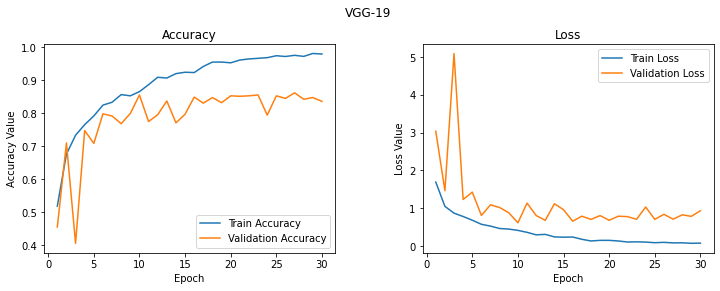

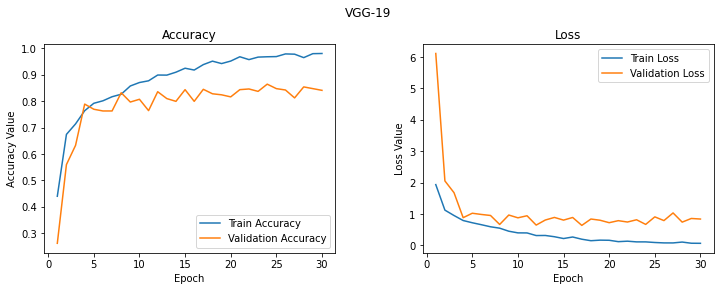

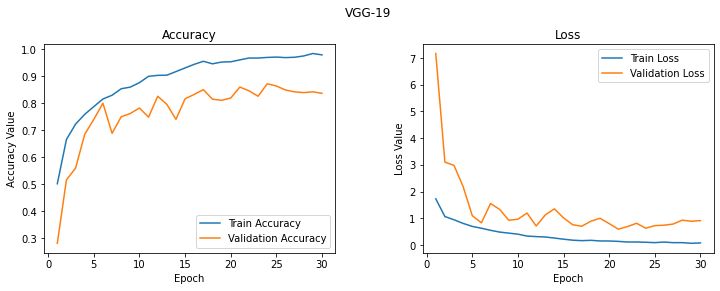

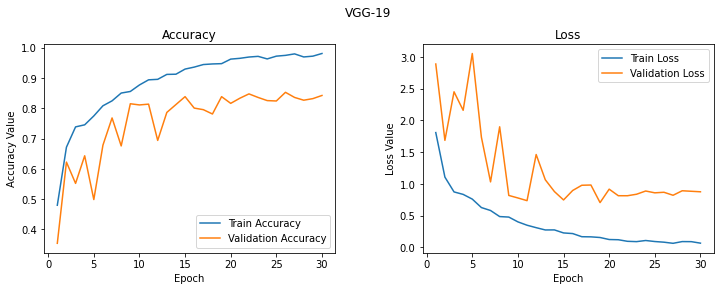

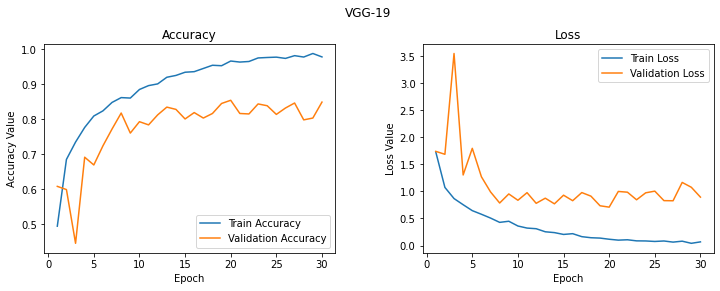

In [10]:
trainModelDF(
    traindf,
    cross_validation_folds = 5,
    epochs = 30
)

In [16]:
def trainFinalModel(images, epochs):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=10,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1)
    
    print("======================================")    
    model = createModel()
    print("======================================")
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=images,
                                                  directory="/content/drive/My Drive/DataMining/google",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(224, 224));
        
    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    
    #Trains the model on data generated batch-by-batch by a Python generator
    model.fit_generator(generator = train_generator,\
                        steps_per_epoch = STEP_SIZE_TRAIN, \
                        epochs = epochs, \
                        verbose = 1)

In [17]:
trainFinalModel(
    traindf,
    epochs = 30
)

Train Model
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_28 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 4096)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 442 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3878 validated image filenames belonging to 13 classes.
Epoch 1/30
  1/121 [..............................] - ETA: 4s - loss: 3.6573 - accuracy: 0.0938

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


121/121 [==============================] - 65s 534ms/step - loss: 1.5882 - accuracy: 0.5439
Epoch 2/30
121/121 [==============================] - 65s 535ms/step - loss: 1.0299 - accuracy: 0.7010
Epoch 3/30
121/121 [==============================] - 64s 530ms/step - loss: 0.8094 - accuracy: 0.7566
Epoch 4/30
121/121 [==============================] - 65s 540ms/step - loss: 0.7406 - accuracy: 0.7751
Epoch 5/30
121/121 [==============================] - 64s 531ms/step - loss: 0.6532 - accuracy: 0.8045
Epoch 6/30
121/121 [==============================] - 65s 535ms/step - loss: 0.5685 - accuracy: 0.8232
Epoch 7/30
121/121 [==============================] - 64s 530ms/step - loss: 0.5021 - accuracy: 0.8463
Epoch 8/30
121/121 [==============================] - 64s 530ms/step - loss: 0.4649 - accuracy: 0.8606
Epoch 9/30
121/121 [==============================] - 64s 530ms/step - loss: 0.4022 - accuracy: 0.8807
Epoch 10/30
121/121 [==============================] - 65s 537ms/step - loss: 0.3691

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
testdf = pd.read_csv('test.csv')

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = "./../DataMining/AllData/filtered/images/",
    x_col = "chart",
    y_col = None,
    batch_size = 1,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (224, 224))

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n // test_generator.batch_size

pred = loaded_model.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

In [ ]:
predicted_class_indices = np.argmax(pred, axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames = test_generator.filenames

results = pd.DataFrame({"chart": filenames, "type": predictions})
results.to_csv("predictions.csv", index = False)

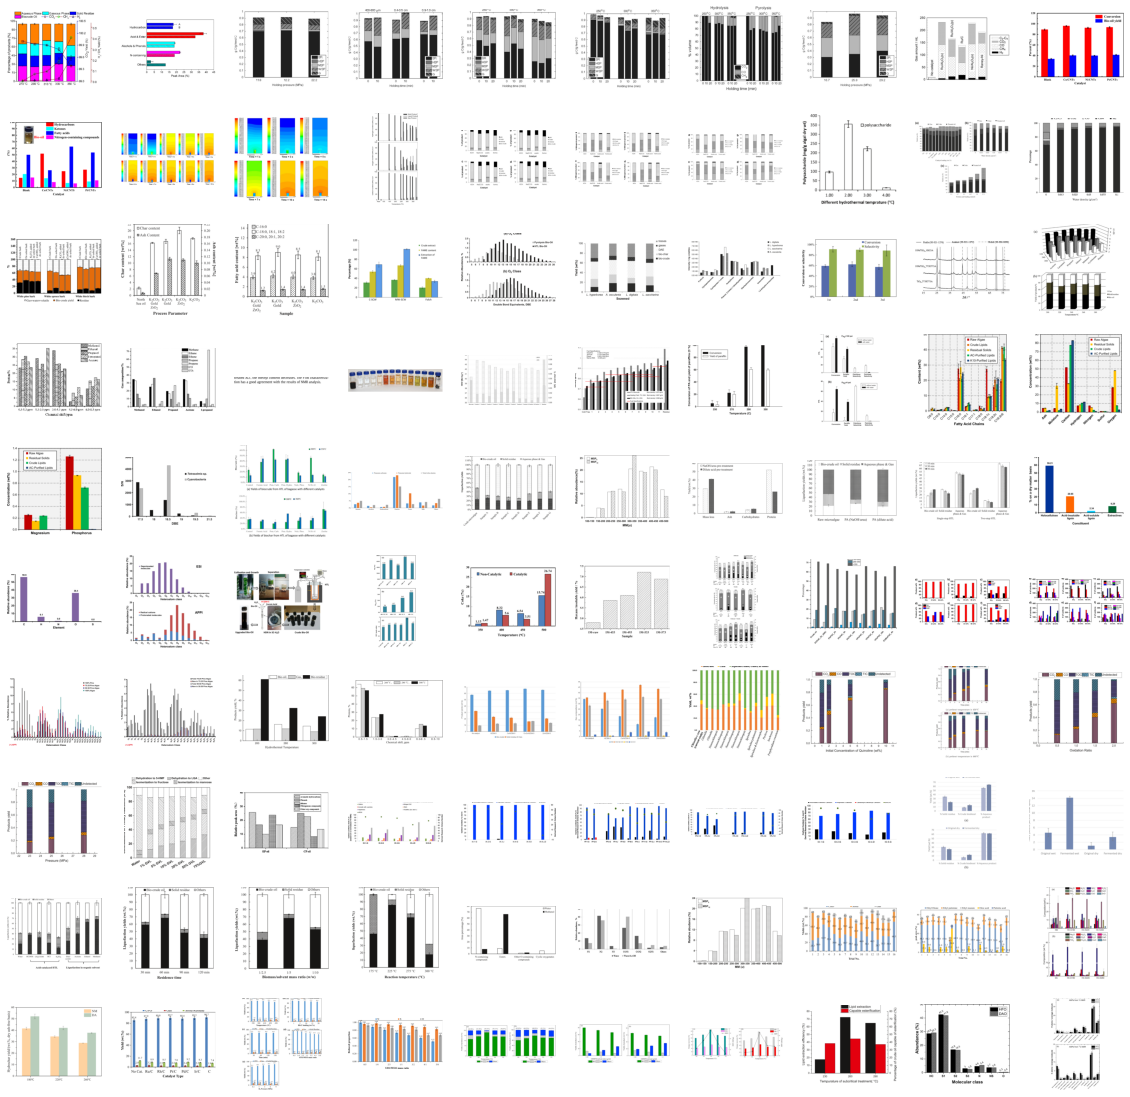

In [7]:
barplots = results.loc[results['type'] == 'BarGraph']

f, ax = plt.subplots(10, 10, figsize = (20, 20))

for index in range(100):
    ax[index // 10, index % 10].imshow(mpimg.imread("./../../DataMining/AllData/filtered/images/" + barplots.iloc[index]['chart']))
    ax[index // 10, index % 10].axis('off')
    ax[index // 10, index % 10].set_aspect('equal')
    
plt.show()